# Plot summer peaks and winter peaks along the centerline with weather and terminus data


In [1]:
import xarray as xr
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import scipy

## Load datasets

In [2]:
data_path = '/Users/raineyaberle/Research/Hubbard/'
out_path = '/Users/raineyaberle/Research/Hubbard/figures/'
crs = 'EPSG:3338'

# -----Velocity
ds_fn = os.path.join(data_path, 'velocity', 'Hubbard_S1.nc')
ds = xr.load_dataset(ds_fn)
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
ds = ds.rio.write_crs('EPSG:3413')
ds = ds.rio.reproject(crs)
ds = xr.where(ds > 1e10, np.nan, ds)
ds = xr.where(ds==0, np.nan, ds)

# -----Air temperature --> PDDs
air_fn = os.path.join(data_path, 'weather', 'Yakutat_2000_2023.csv')
air = pd.read_csv(air_fn)
# remove empty columns
air = air[[x for x in list(air.columns) if 'Unnamed' not in x]]
air['Date_Time'] = pd.DatetimeIndex(air['Date_Time'])
air.rename(columns={'Date_Time': 'Date'}, inplace=True)

# -----Centerline
cl_fn = os.path.join(data_path, 'velocity', 'center_50m.gpkg')
cl_gdf = gpd.read_file(cl_fn)
cl_gdf = cl_gdf.to_crs(crs)
cl_x, cl_y = cl_gdf.geometry[0].coords.xy[0], cl_gdf.geometry[0].coords.xy[1]

# -----Terminus
term_fn = os.path.join(data_path, 'terminus', 'terminus_position_smooth.csv')
term = pd.read_csv(term_fn)
term['Date'] = pd.to_datetime(term['Date'])
term.drop_duplicates(inplace=True)
term['Mean_position_m'] = term[['section_A [m]', 'section_B1 [m]', 'section_B2 [m]', 'section_C [m]']].mean(axis=1)
term['Mean_position_section_B_m'] = term[['section_B1 [m]', 'section_B2 [m]']].mean(axis=1)
# Calculate the negative to measure retreat as positive
term['Mean_retreat_m'] = -term['Mean_position_m']
term['Mean_retreat_section_B_m'] = -term['Mean_position_section_B_m']
# Resample to daily
term.set_index('Date', inplace=True)
term = term.resample('1D').interpolate('time')
term.reset_index(inplace=True)
# Calculate mean retreat rate [m/d]
term['Mean_retreat_rate_m/d'] = term['Mean_retreat_m'].diff()

## Calculate max cumulative PDDs and terminus retreat each year

<Axes: xlabel='Date'>

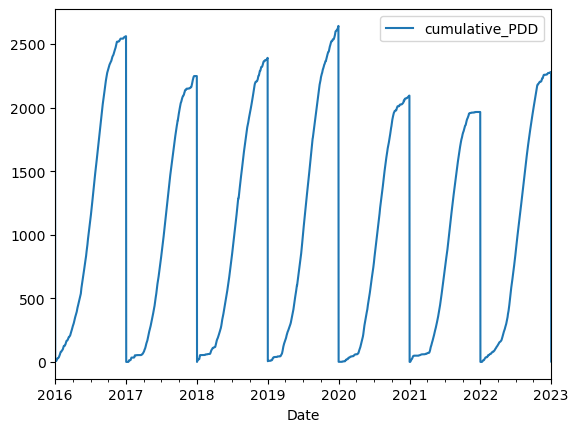

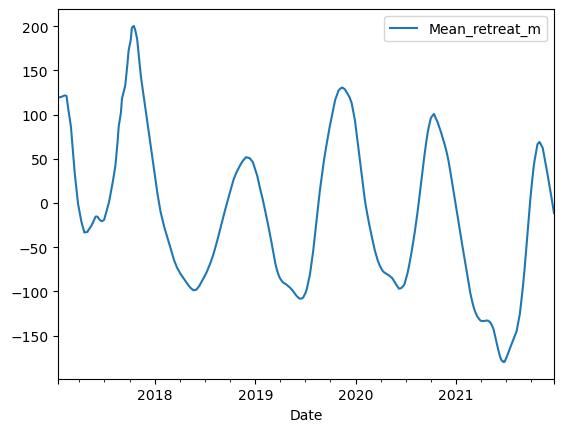

In [3]:
years = np.arange(2017, 2023)

# Cumulative PDD peaks
def calculate_pdd(temp):
    if temp > 0:
        return temp
    else:
        return 0
air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
air['cumulative_PDD'] = air.groupby(air['Date'].dt.year)['PDD'].cumsum()
pdd_peaks = air.groupby(air['Date'].dt.year)['cumulative_PDD'].max().reset_index()
pdd_peaks.rename(columns={'Date':'Year'}, inplace=True)
pdd_peaks = pdd_peaks.loc[pdd_peaks['Year'].isin(years)]
pdd_peaks.rename(columns={'cumulative_PDD': 'cumulative_PDD_max'}, inplace=True)
pdd_peaks.reset_index(drop=True, inplace=True)
air.plot(x='Date', y='cumulative_PDD')
plt.xlim(np.datetime64('2016-01-01'), np.datetime64('2023-01-01'))

# Terminus retreat peaks
# Subset to end of the year
term_retreat_peaks = term.loc[term['Date'].dt.month >= 6]
term_retreat_peaks = term_retreat_peaks.groupby(term_retreat_peaks['Date'].dt.year)['Mean_retreat_m'].max().reset_index()
term_retreat_peaks.rename(columns={'Date':'Year'}, inplace=True)
term_retreat_peaks = term_retreat_peaks.loc[term_retreat_peaks['Year'].isin(years)]
term_retreat_peaks.rename(columns={'Mean_retreat_m': 'max_terminus_retreat_m'}, inplace=True)
term.plot(x='Date', y='Mean_retreat_m')

## Calculate mean centerline speed over full time period

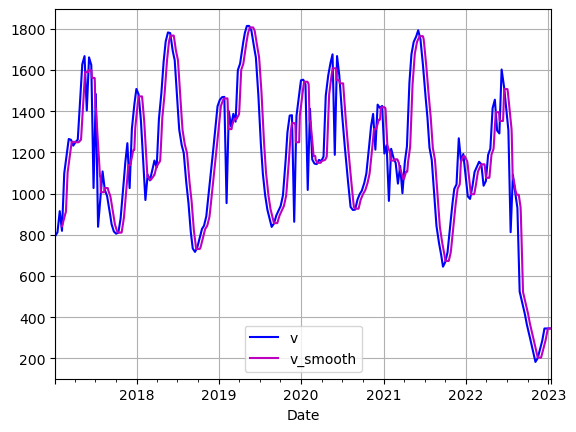

In [4]:
# Calculate mean speed along centerline
v_mean_cl = ds.sel(x=cl_x, y=cl_y, method='nearest').mean(dim='x').mean(dim='y')
# Subset to after 2016
year_mask = v_mean_cl.year > 2016
v_mean_cl_sub = v_mean_cl.v[year_mask]
# Convert to pandas.DataFrame
v_mean_cl_df = pd.DataFrame({'Date': v_mean_cl_sub.time.data,
                             'v': v_mean_cl_sub.data})
v_mean_cl_df.set_index('Date', inplace=True)

# Resample to daily resolution
daily_index = pd.date_range(start=v_mean_cl_df.index.min(), end=v_mean_cl_df.index.max(), freq='D')
v_mean_cl_df = v_mean_cl_df.reindex(daily_index)
# Interpolate missing values
v_mean_cl_df['v'] = v_mean_cl_df['v'].interpolate(method='linear')

# Apply moving median
v_mean_cl_df['v_smooth'] = v_mean_cl_df['v'].rolling(30).median()
v_mean_cl_df.reset_index(inplace=True)
v_mean_cl_df = v_mean_cl_df.rename(columns={'index': 'Date'})

# Plot
fig, ax = plt.subplots()
v_mean_cl_df.plot(x='Date', y='v', color='b', ax=ax)
v_mean_cl_df.plot(x='Date', y='v_smooth', color='m', ax=ax)
plt.legend(loc='lower center')
plt.grid()
plt.show()

## Calculate winter and summer speed peak strengths along centerline

Adapted from Amy's code in the `doublestrength` folder

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_10290/2913366393.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  winter_strengths = pd.concat([winter_strengths, winter_df])
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_10290/2913366393.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summer_strengths= pd.concat([summer_strengths, summer_df])


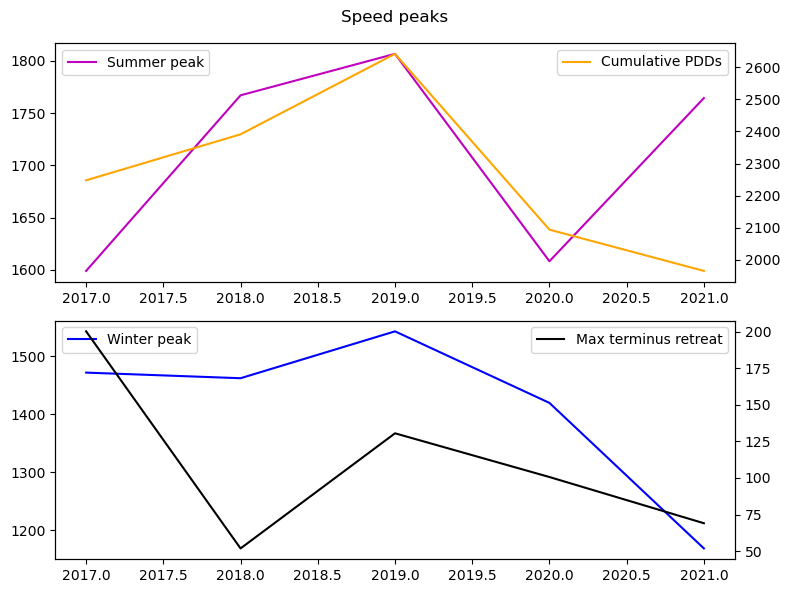

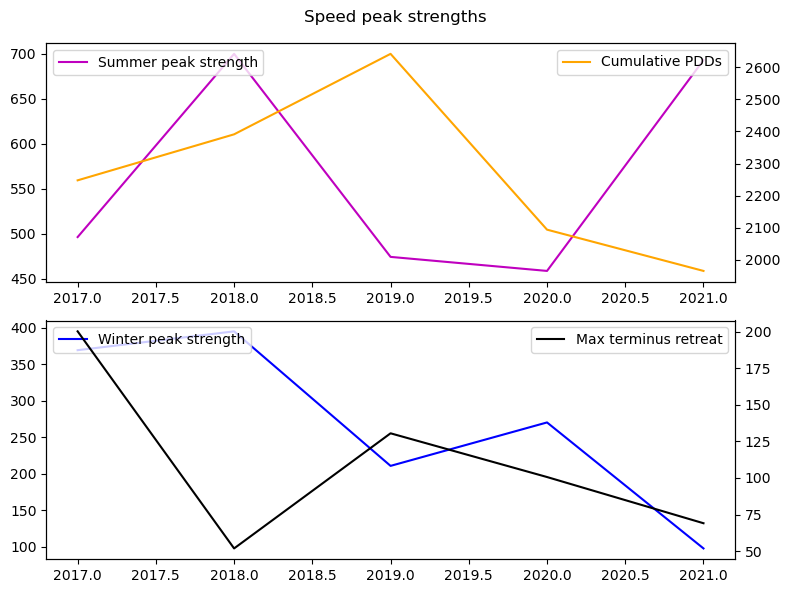

,Year,cumulative_PDD_max,max_terminus_retreat_m,winter_peak_m_per_a,winter_peak_strength_m_per_a,summer_peak_m_per_a,summer_peak_strength_m_per_a
0,2017,2247.619332,200.286522,1471.910944,369.221238,1599.082535,496.392829
1,2018,2391.050994,51.802420,1462.229747,395.043841,1767.148772,699.962865
2,2019,2641.913461,130.550050,1543.017321,210.571563,1806.825343,474.379585
3,2020,2093.838591,100.640109,1419.689911,270.140056,1608.330748,458.780893
4,2021,1965.187097,69.035209,1168.869122,97.387359,1764.515718,693.033955


In [5]:
# fig, ax = plt.subplots()
winter_strengths = pd.DataFrame(columns=['Year', 'winter_peak_m_per_a', 'winter_peak_strength_m_per_a'])
summer_strengths = pd.DataFrame(columns=['Year', 'summer_peak_m_per_a', 'summer_peak_strength_m_per_a'])

for year in years:
    # Winter peak
    v_winter = v_mean_cl_df.loc[(v_mean_cl_df.Date.dt.month <= 1) 
                                & (v_mean_cl_df.Date.dt.year == year+1)].reset_index(drop=True)
    winter_peak = v_winter['v_smooth'].max()
        
    # Middle minimum
    v_mid = v_mean_cl_df.loc[(v_mean_cl_df.Date.dt.month > 2)
                                & (v_mean_cl_df.Date.dt.month < 4)
                                & (v_mean_cl_df.Date.dt.year == year)].reset_index(drop=True)
    middle_min = v_mid['v_smooth'].min()
    
    # Summer peak
    v_summer = v_mean_cl_df.loc[(v_mean_cl_df.Date.dt.month >= 4)
                                & (v_mean_cl_df.Date.dt.month <= 6)
                                & (v_mean_cl_df.Date.dt.year == year)].reset_index(drop=True)
    summer_peak = v_summer['v_smooth'].max()

    # Peak strengths
    winter_strength = winter_peak - middle_min
    summer_strength = summer_peak - middle_min
    
    # Mean peak strengths
    winter_df = pd.DataFrame({'Year': [year],
                              'winter_peak_m_per_a': [winter_peak],
                              'winter_peak_strength_m_per_a': [winter_strength]})
    winter_strengths = pd.concat([winter_strengths, winter_df])
    summer_df = pd.DataFrame({'Year': [year],
                              'summer_peak_m_per_a': [summer_peak],
                              'summer_peak_strength_m_per_a': [summer_strength]})
    summer_strengths= pd.concat([summer_strengths, summer_df])
    
# Combine into dataframe
peaks_df = pd.DataFrame()
peaks_df['Year'] = years
peaks_df = pd.merge(peaks_df, pdd_peaks, on='Year')
peaks_df = pd.merge(peaks_df, term_retreat_peaks, on='Year')
winter_strengths.reset_index(drop=True, inplace=True)
summer_strengths.reset_index(drop=True, inplace=True)
peaks_df = pd.merge(peaks_df, winter_strengths, on='Year')
peaks_df = pd.merge(peaks_df, summer_strengths, on='Year')

# Plot peaks
cols = list(peaks_df.columns[1:])
fig, ax = plt.subplots(2, 1, figsize=(8,6))
# Summer peak strength & cumsum(PDDs)
ax[0].plot(peaks_df['Year'], peaks_df['summer_peak_m_per_a'], '-m', label='Summer peak')
ax[0].legend(loc='upper left')
ax2 = ax[0].twinx()
ax2.plot(peaks_df['Year'], peaks_df['cumulative_PDD_max'], '-', color='orange', label='Cumulative PDDs')
ax2.legend(loc='upper right')
# Winter peak strength & terminus retreat
ax[1].plot(peaks_df['Year'], peaks_df['winter_peak_m_per_a'], '-b', label='Winter peak')
ax[1].legend(loc='upper left')
ax2 = ax[1].twinx()
ax2.plot(peaks_df['Year'], peaks_df['max_terminus_retreat_m'], '-k', label='Max terminus retreat')
ax2.legend(loc='upper right')
fig.suptitle('Speed peaks')
fig.tight_layout()

# Plot peak strengths
cols = list(peaks_df.columns[1:])
fig, ax = plt.subplots(2, 1, figsize=(8,6))
# Summer peak strength & cumsum(PDDs)
ax[0].plot(peaks_df['Year'], peaks_df['summer_peak_strength_m_per_a'], '-m', label='Summer peak strength')
ax[0].legend(loc='upper left')
ax2 = ax[0].twinx()
ax2.plot(peaks_df['Year'], peaks_df['cumulative_PDD_max'], '-', color='orange', label='Cumulative PDDs')
ax2.legend(loc='upper right')
# Winter peak strength & terminus retreat
ax[1].plot(peaks_df['Year'], peaks_df['winter_peak_strength_m_per_a'], '-b', label='Winter peak strength')
ax[1].legend(loc='upper left')
ax2 = ax[1].twinx()
ax2.plot(peaks_df['Year'], peaks_df['max_terminus_retreat_m'], '-k', label='Max terminus retreat')
ax2.legend(loc='upper right')
fig.suptitle('Speed peak strengths')
fig.tight_layout()


plt.show()

peaks_df

## Calculate cross-correlations between cumulative PDDs and speed and terminus

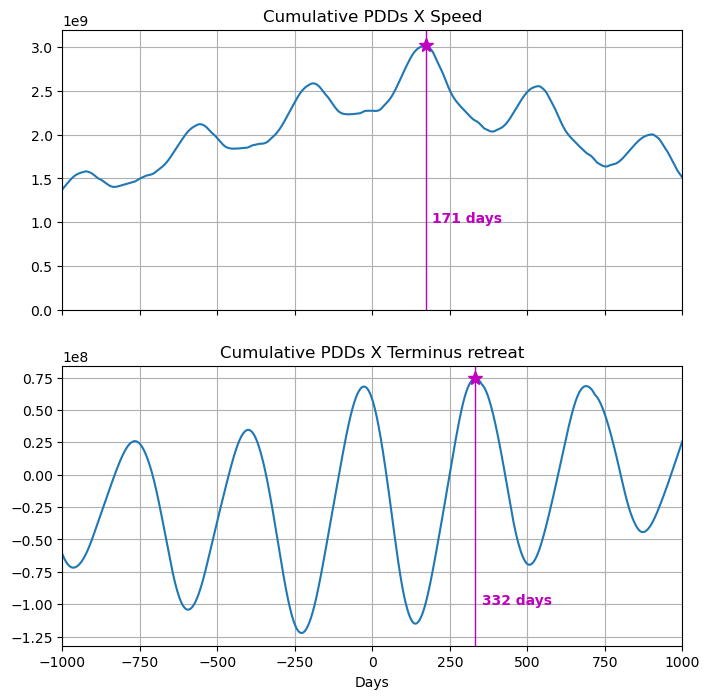

In [6]:
from scipy.signal import correlate

# PDD-Speed
pdd_v_merge = pd.merge(air[['Date', 'cumulative_PDD']], v_mean_cl_df[['Date', 'v']], on='Date')
pdd_v_merge.dropna(inplace=True)
xcorr_pdd_v = correlate(pdd_v_merge['cumulative_PDD'], pdd_v_merge['v'], mode='full')
xcorr_pdd_v_days = np.arange(-len(xcorr_pdd_v)/2, len(xcorr_pdd_v)/2, step=1)
# PDD-Terminus
pdd_term_merge = pd.merge(air[['Date', 'cumulative_PDD']], term[['Date', 'Mean_retreat_m']], on='Date')
pdd_term_merge.dropna(inplace=True)
xcorr_pdd_term = correlate(pdd_term_merge['cumulative_PDD'], pdd_term_merge['Mean_retreat_m'], mode='full')
xcorr_pdd_term_days = np.arange(-len(xcorr_pdd_term)/2, len(xcorr_pdd_term)/2, step=1)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True)
ax[0].plot(xcorr_pdd_v_days, xcorr_pdd_v)
ax[0].set_xlim(-1e3, 1e3)
ax[0].set_ylim(0, 3.2e9)
imax = np.argmax(xcorr_pdd_v)
ax[0].axvline(xcorr_pdd_v_days[imax], color='m', linewidth=1)
ax[0].plot(xcorr_pdd_v_days[imax], xcorr_pdd_v[imax], '*m', markersize=10)
ax[0].text(xcorr_pdd_v_days[imax] + 20, 1e9, f'{int(xcorr_pdd_v_days[imax])} days', color='m', fontweight='bold')
ax[0].grid()
ax[0].set_title('Cumulative PDDs X Speed')

ax[1].plot(xcorr_pdd_term_days, xcorr_pdd_term)
imax = np.argmax(xcorr_pdd_term)
ax[1].axvline(xcorr_pdd_term_days[imax], color='m', linewidth=1)
ax[1].plot(xcorr_pdd_term_days[imax], xcorr_pdd_term[imax], '*m', markersize=10)
ax[1].text(xcorr_pdd_term_days[imax] + 20, -1e8, f'{int(xcorr_pdd_term_days[imax])} days', color='m', fontweight='bold')
ax[1].grid()
ax[1].set_title('Cumulative PDDs X Terminus retreat')
ax[1].set_xlabel('Days')

plt.show()

## Plot all results on one figure

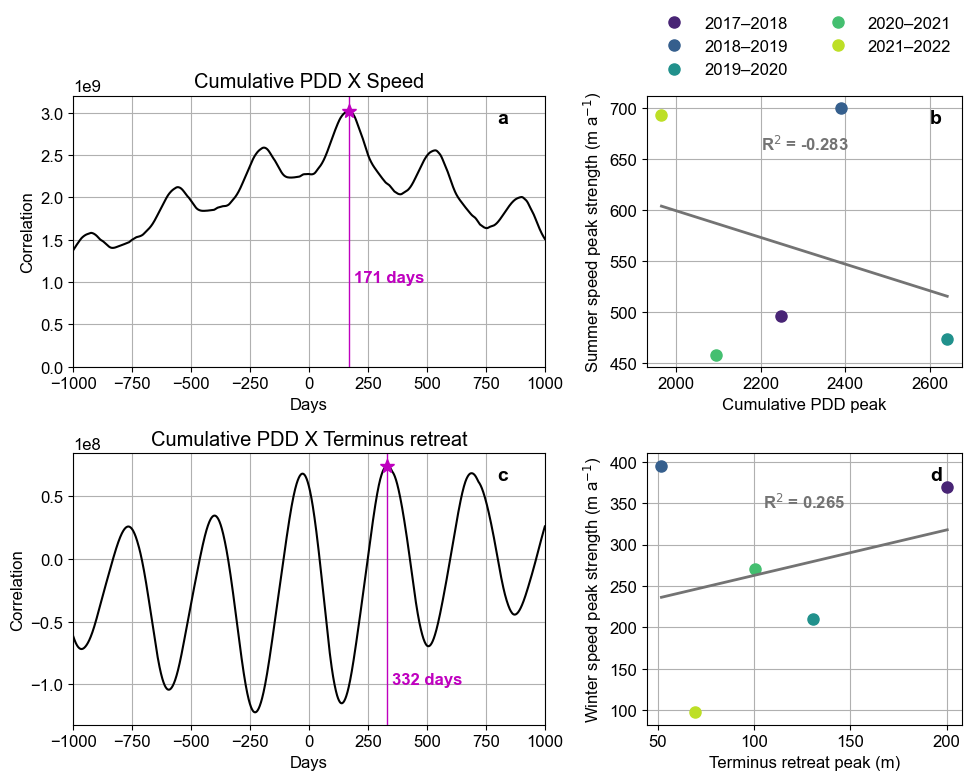

Figure saved to file: /Users/raineyaberle/Research/Hubbard/figures/correlations_summer_winter_speed_peaks.png


In [7]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(2,2,figsize=(10,8), gridspec_kw=dict(width_ratios=[1.5, 1]))
ax = ax.flatten()

### a) PDD X Speed
ax[0].plot(xcorr_pdd_v_days, xcorr_pdd_v, '-k')
ax[0].set_ylim(0, 3.2e9)
imax = np.argmax(xcorr_pdd_v)
ax[0].axvline(xcorr_pdd_v_days[imax], color='m', linewidth=1)
ax[0].plot(xcorr_pdd_v_days[imax], xcorr_pdd_v[imax], '*m', markersize=10)
ax[0].text(xcorr_pdd_v_days[imax] + 20, 1e9, f'{int(xcorr_pdd_v_days[imax])} days', color='m', fontweight='bold')
ax[0].set_title('Cumulative PDD X Speed')

### b) PDD X Terminus retreat
ax[2].plot(xcorr_pdd_term_days, xcorr_pdd_term, '-k')
imax = np.argmax(xcorr_pdd_term)
ax[2].axvline(xcorr_pdd_term_days[imax], color='m', linewidth=1)
ax[2].plot(xcorr_pdd_term_days[imax], xcorr_pdd_term[imax], '*m', markersize=10)
ax[2].text(xcorr_pdd_term_days[imax] + 20, -1e8, f'{int(xcorr_pdd_term_days[imax])} days', color='m', fontweight='bold')
ax[2].set_title('Cumulative PDD X Terminus retreat')
for axis in [ax[0], ax[2]]:
    axis.set_xlim(-1e3, 1e3)
    axis.set_xlabel('Days')
    axis.set_ylabel('Correlation')

### c) PDD vs. Summer peak strength and d) Terminus retreat vs. Winter peak strength regressions
regression_color = '#737373' 
cmap = plt.cm.viridis
peaks_df['color'] = [cmap(i) for i in 
                     ((peaks_df['Year']+0.5 - np.min(peaks_df['Year'])) / len(peaks_df)).values]
Xcols = ['cumulative_PDD_max', 'max_terminus_retreat_m']
Xlabels = ['Cumulative PDD peak', 'Terminus retreat peak (m)']
Ycols = ['summer_peak_strength_m_per_a', 'winter_peak_strength_m_per_a']
Ylabels = ['Summer speed peak strength (m a$^{-1}$)', 'Winter speed peak strength (m a$^{-1}$)']
titles = ['Summer', 'Winter']

for i, Xcol, Xlabel, Ycol, Ylabel in zip([1, 3], Xcols, Xlabels, Ycols, Ylabels):
    # scatter plot
    for year in peaks_df['Year'].values:
        df = peaks_df.loc[peaks_df['Year']==year]
        ax[i].plot(df[Xcol], df[Ycol], 'o', color=df['color'].values[0], 
                   markersize=8, label=f'{year}–{year+1}') 
    ax[i].set_xlabel(Xlabel)
    ax[i].set_ylabel(Ylabel)
    # linear regression lines
    X, y = peaks_df[Xcol].values, peaks_df[Ycol].values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, y)
    Xmod = np.linspace(np.nanmin(X), np.nanmax(X), num=100)
    ymod = Xmod*slope + intercept
    ax[i].plot(Xmod, ymod, '-', color=regression_color, linewidth=2)
    ax[i].text((ax[i].get_xlim()[1] - ax[i].get_xlim()[0])*0.5 + ax[i].get_xlim()[0], 
               (ax[i].get_ylim()[1] - ax[i].get_ylim()[0])*0.8 + ax[i].get_ylim()[0], 
               f'R$^2$ = {np.round(r_value, 3)}', horizontalalignment='center', 
               fontweight='bold', color=regression_color)
# Add legend
ax[1].legend(loc='upper center', bbox_to_anchor=[0.4, 1.15, 0.2, 0.2], ncols=2, frameon=False)

# Add panel labels
labels = ['a', 'b', 'c', 'd']
for i, axis in enumerate(ax):
    axis.text(axis.get_xlim()[0] + (axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.9,
              axis.get_ylim()[0] + (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.9,
              labels[i], fontsize=fontsize+2, fontweight='bold')
    axis.grid()

fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(out_path, 'correlations_speed_peaks.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

## Plot only the speed peak regressions

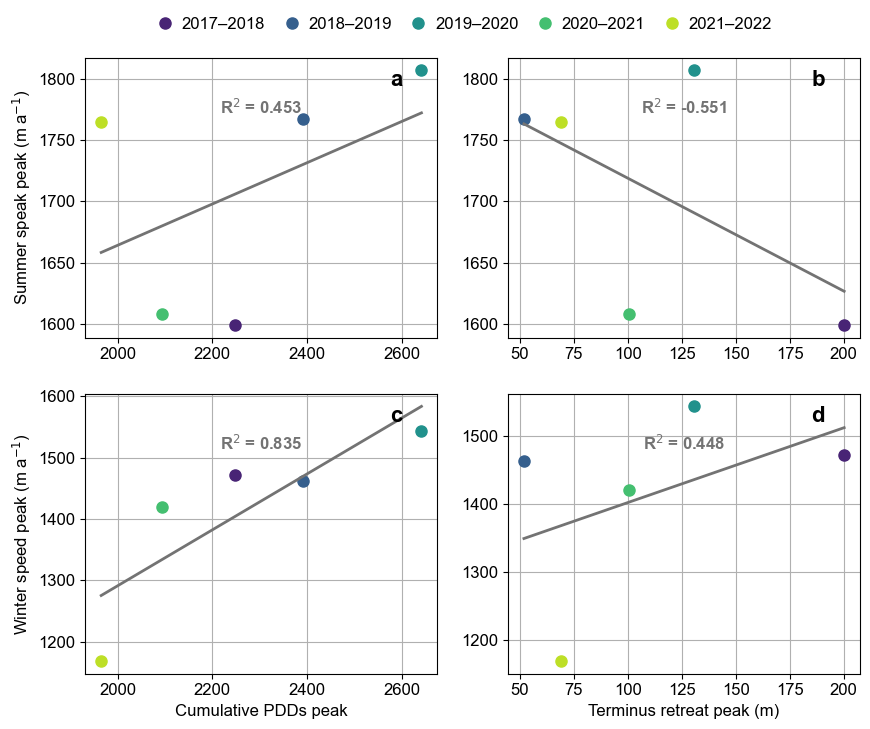

Figure saved to file: /Users/raineyaberle/Research/Hubbard/figures/speed_peaks_vs_weather_terminus.png


In [19]:
# Determine whether to plot peaks or peak strengths
strengths = False

# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(2,2,figsize=(10,8))

# Plot settings
regression_color = '#737373'
cmap = plt.cm.viridis
peaks_df['color'] = [cmap(i) for i in 
                     ((peaks_df['Year']+0.5 - np.min(peaks_df['Year'])) / len(peaks_df)).values]
Xcols = ['cumulative_PDD_max', 'max_terminus_retreat_m']
Xlabels = ['Cumulative PDDs peak', 'Terminus retreat peak (m)']
if strengths:
    Ycols = ['summer_peak_strength_m_per_a', 'winter_peak_strength_m_per_a']
    Ylabels = ['Summer speak peak strength (m a$^{-1}$)', 'Winter speed peak strength (m a$^{-1}$)']
else:
    Ycols = ['summer_peak_m_per_a', 'winter_peak_m_per_a']
    Ylabels = ['Summer speak peak (m a$^{-1}$)', 'Winter speed peak (m a$^{-1}$)']    
panel_labels = [['a', 'b'], ['c', 'd']]

# Iterate over columns
for i in range(len(Xcols)):
    for j in range(len(Ycols)):
        # scatter plot
        for year in peaks_df['Year'].values:
            df = peaks_df.loc[peaks_df['Year']==year]
            ax[j,i].plot(df[Xcols[i]], df[Ycols[j]], 'o', color=df['color'].values[0], 
                         markersize=8, label=f'{year}–{year+1}')            
        if j==1:
            ax[j,i].set_xlabel(Xlabels[i])
        if i==0:
            ax[j,i].set_ylabel(Ylabels[j])
        ax[j,i].grid()
        # linear regression lines
        X, y = peaks_df[Xcols[i]].values, peaks_df[Ycols[j]].values
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, y)
        Xmod = np.linspace(np.nanmin(X), np.nanmax(X), num=100)
        ymod = Xmod*slope + intercept
        ax[j,i].plot(Xmod, ymod, '-', color=regression_color, linewidth=2)
        ax[j,i].text((ax[j,i].get_xlim()[1] - ax[j,i].get_xlim()[0])*0.5 + ax[j,i].get_xlim()[0], 
                     (ax[j,i].get_ylim()[1] - ax[j,i].get_ylim()[0])*0.8 + ax[j,i].get_ylim()[0], 
                     f'R$^2$ = {np.round(r_value, 3)}', horizontalalignment='center', fontweight='bold', color=regression_color)
        ax[j,i].text((ax[j,i].get_xlim()[1] - ax[j,i].get_xlim()[0])*0.9 + ax[j,i].get_xlim()[0], 
                     (ax[j,i].get_ylim()[1] - ax[j,i].get_ylim()[0])*0.9 + ax[j,i].get_ylim()[0], 
                     panel_labels[j][i], horizontalalignment='right', fontweight='bold', fontsize=fontsize+4)        
        
# add legend
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncols=len(peaks_df),  
           labelspacing=0.2, columnspacing=0.6, handletextpad = 0.0, markerscale=1,
           bbox_to_anchor=[0.4, 0.75, 0.2, 0.2], frameon=False)

# fig.tight_layout()
plt.show()

# Save figure
if strengths:
    fig_fn = os.path.join(out_path, 'speed_peak_strengths_vs_weather_terminus.png')
else:
    fig_fn = os.path.join(out_path, 'speed_peaks_vs_weather_terminus.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

In [38]:
## Calculate cross-correlation between 

array([-2187.5, -2186.5, -2185.5, ...,  2184.5,  2185.5,  2186.5])

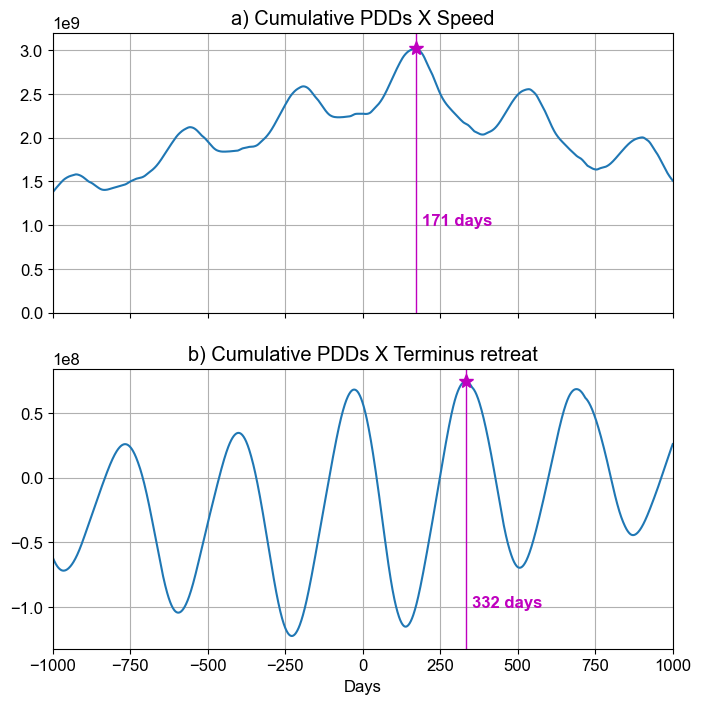

In [62]:
v



plt.show()

## Decompose velocity into two seasonal signals

In [ ]:
# v_mean_cl_df['Days'] = (np.array(v_mean_cl_df.index) 
#                         - np.datetime64(v_mean_cl_df.index[0])).astype('timedelta64[D]').astype(int)
# v_mean_cl_df

In [ ]:
# v_summer = v_mean_cl_df.loc[(v_mean_cl_df.index.month >= 4) & (v_mean_cl_df.index.month <= 6)]
# ipeaks = v_summer.groupby(v_summer.index.year)['v'].idxmax()
# summer_peaks = v_summer.loc[ipeaks]

# v_mids = v_mean_cl_df.loc[(v_mean_cl_df.index.month <= 2)]
# ipeaks = v_mids.groupby(v_mids.index.year)['v'].idxmin()
# mids = v_mids.loc[ipeaks]

# v_mins = v_mean_cl_df.loc[(v_mean_cl_df.index.month >= 6) & (v_mean_cl_df.index.month <= 10)]
# ipeaks = v_mins.groupby(v_mins.index.year)['v'].idxmin()
# mins = v_mins.loc[ipeaks]

# v_winter = v_mean_cl_df.loc[(v_mean_cl_df.index.month <= 2) | (v_mean_cl_df.index.month >= 11)]
# ipeaks = v_winter.groupby(v_winter.index.year)['v'].idxmax()
# winter_peaks = v_winter.loc[ipeaks]


# # Winter signal
# winter_signal = pd.concat([pd.concat([winter_peaks, mins]), mids])
# winter_signal.drop_duplicates(inplace=True)
# peaks.sort_index(inplace=True)
# # Resample to daily resolution
# daily_index = pd.date_range(start=v_mean_cl_df.index.min(), end=v_mean_cl_df.index.max(), freq='D')
# winter_signal = winter_signal.reindex(daily_index)
# # Apply smoothing spline
# winter_signal['v'] = winter_signal['v'].interpolate(method='pchip')

# # Summer signal
# summer_signal = pd.concat([pd.concat([summer_peaks, mins]), mids])
# summer_signal.drop_duplicates(inplace=True)
# peaks.sort_index(inplace=True)
# # Resample to daily resolution
# summer_signal = summer_signal.reindex(daily_index)
# # Apply smoothing spline
# summer_signal['v'] = summer_signal['v'].interpolate(method='pchip')

# # Plot
# fig, ax = plt.subplots()
# winter_signal.plot(y='v', color='b', ax=ax)
# summer_signal.plot(y='v', color='orange', ax=ax)
# plt.show()

# # Combine
# # peaks = pd.concat([summer_peaks, winter_peaks])
# # peaks = pd.concat([peaks, mins])
# # peaks = pd.concat([peaks, mids])
# # peaks.sort_index(inplace=True)
# # peaks.plot(y='v')
# # plt.show()

In [ ]:
# from scipy.optimize import curve_fit

# def model_func(t, A1, phase1, A2, phase2):
#     return (A1 * np.sin(2 * np.pi * t / 365 + phase1) +
#             A2 * np.sin(2 * np.pi * t / 365 + phase2))
    
# # Fit the model to the data
# params, _ = curve_fit(model_func, v_mean_cl_df.Days, v_mean_cl_df['v'], p0=[1, 0, 0.5, np.pi / 4])

# # Extract the fitted parameters
# A1, phase1, A2, phase2 = params

# # Generate the fitted components
# fitted_signal1 = A1 * np.sin(2 * np.pi * v_mean_cl_df.Days / 365 + phase1)
# fitted_signal2 = A2 * np.sin(2 * np.pi * v_mean_cl_df.Days / 365 + phase2)

# # Plot results
# plt.figure(figsize=(12, 8))
# plt.subplot(411)
# plt.plot(v_mean_cl_df.Days, v_mean_cl_df['v'], label='Original Combined Signal')
# plt.legend()
# plt.subplot(412)
# plt.plot(v_mean_cl_df.Days, fitted_signal1, label='Separated Signal 1')
# plt.legend()
# plt.subplot(413)
# plt.plot(v_mean_cl_df.Days, fitted_signal2, label='Separated Signal 2')
# plt.legend()
# plt.subplot(414)
# plt.plot(v_mean_cl_df.Days, v_mean_cl_df['v'].values - (fitted_signal1 + fitted_signal2), label='Residual')
# plt.tight_layout()
# plt.show()

## Decompose speeds into trend + seasonal + residual signals

In [ ]:
# # Decompose into seasonal signals
# from statsmodels.tsa.seasonal import seasonal_decompose
# v_mean_cl_df.set_index('Date', inplace=True)
# v_decomposed = seasonal_decompose(v_mean_cl_df, model='additive', period=365, extrapolate_trend=True)

# v_decomposed.plot()
# plt.show()

# # Convert to pandas.DataFrame
# v_decomposed_df = (v_decomposed.trend + v_decomposed.seasonal).reset_index()
# v_decomposed_df = v_decomposed_df.rename(columns={'index': 'Date',
#                                                   0: 'v'})
# (v_decomposed.seasonal + v_decomposed.trend).plot()

## Calculate cross-correlation between speed, terminus, and PDDs

In [ ]:
# -----Resample terminus to daily
if type(term.index)!=pd.DatetimeIndex:
    term.set_index('Date', inplace=True)
term_resamp = term.resample('1D').interpolate()
term_resamp.reset_index(inplace=True)

# -----Convert mean centerline speed to dataframe
v_mean_cl_df = pd.DataFrame({'Date': v_mean_cl.time.data,
                             'v': v_mean_cl.v.data})
v_mean_cl_df.dropna(inplace=True)


In [ ]:
# -----Calculate X-corr and plot
def Xcorr(df1, col1, df2, col2):
    df_merged = df1.merge(df2, on='Date')
    xcorr = scipy.signal.correlate(df_merged[col1], df_merged[col2], mode='full', method='auto')
    days = np.arange(-len(xcorr)/2, len(xcorr)/2)
    Ipeak = np.argwhere(xcorr==np.nanmax(xcorr))
    xcorr_peak, days_peak = xcorr[Ipeak], days[Ipeak]

    return xcorr, days, xcorr_peak, days_peak

fig, ax = plt.subplots(3, 2, figsize=(12,10))
### pdd-speed
df1 = 
xcorr, days, xcorr_peak, days_peak = Xcorr(wx, 'PDD_cumsum', v_mean_df, 'v')
ax[0,0].plot(v_mean_df['Date'], v_mean_df['v'], '-b')
ax2 = ax[0,0].twinx()
ax2.plot(wx['Date'], wx['PDD_cumsum'], '-', color='orange')
ax[0,1].plot(days, xcorr, '-k')
ax[0,1].axvline(days_peak, color='m')
ax[0,1].text(days_peak + 50, ax[0,1].get_ylim()[0]*0.1, f'{days_peak[0][0]} days', color='m', fontweight='bold')
ax[0,1].set_title('Cumulative PDDs X Speed')
ax[0,1].grid()
### terminus-speed
xcorr, days, xcorr_peak, days_peak = Xcorr(v_mean_df, 'v', term_resamp, 'Mean_retreat_m')
ax[1,0].plot(v_mean_df['Date'], v_mean_df['v'], '-b')
ax2 = ax[1,0].twinx()
ax2.plot(term_resamp['Date'], term_resamp['Mean_retreat_m'], '-c')
ax[1,1].plot(days, xcorr, '-k')
ax[1,1].axvline(days_peak, color='m')
ax[1,1].text(days_peak + 50, -1.5e8, f'{days_peak[0][0]} days', color='m', fontweight='bold')
ax[1,1].set_title('Terminus retreat X Speed')
ax[1,1].grid()
### pdd-terminus
xcorr, days, xcorr_peak, days_peak = Xcorr(wx, 'PDD_cumsum', term_resamp, 'Mean_retreat_m')
ax[2,0].plot(wx['Date'], wx['PDD_cumsum'], '-', color='orange')
ax2 = ax[2,0].twinx()
ax2.plot(term_resamp['Date'], term_resamp['Mean_retreat_m'], '-c')
ax[2,1].plot(days, xcorr, '-k')
ax[2,1].axvline(days_peak, color='m')
ax[2,1].text(days_peak + 50, -4.5e7, f'{days_peak[0][0]} days', color='m', fontweight='bold')
ax[2,1].set_title('Cumulative PDDs X Terminus retreat')
ax[2,1].grid()

for axis in [ax[0,0], ax[1,0], ax[2,0]]:
    axis.set_xlim(np.datetime64('2016-01-01'), np.datetime64('2023-01-01'))
for axis in [ax[0,1], ax[1,1], ax[2,1]]:
    axis.set_xlim(-1e3, 1e3)
    
fig.subplots_adjust(hspace=0.4)

plt.show()